In [13]:
import rioxarray as rix
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np 
from shapely.geometry import Point 

# Earth DEM and Snow DSM

## Earth DEM

A digital elevation model (DEM) is aa gridded dataset with one elevation value for each pixel. This can best be understood by looking at one!

Below, we open up the elevation dataset, along with a "hillshade dataset". A hillshade is calculated from a DEM, and essentially mimics shadows to make it easier to understand the topography.

In [2]:
# This is the DEM file
elevation = rix.open_rasterio("../data/east_river_elevation.tif")

# This is the hillshade file
hillshade = rix.open_rasterio("../data/east_river_hillshade.tif", masked=True)

Let's look at the elevation dataset

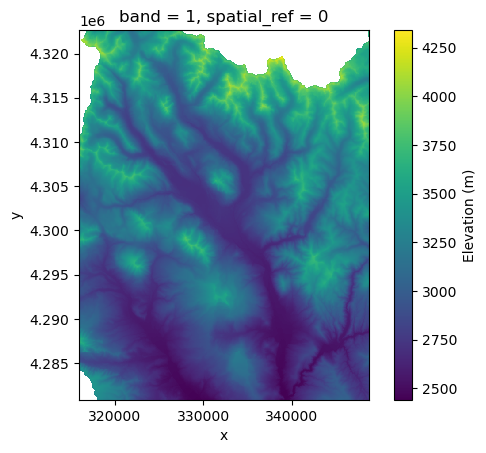

In [3]:
elevation.plot(cbar_kwargs={'label': "Elevation (m)"})
plt.gca().set_aspect('equal') # so that the axes are sized correctly

Now let's look at the hillshade

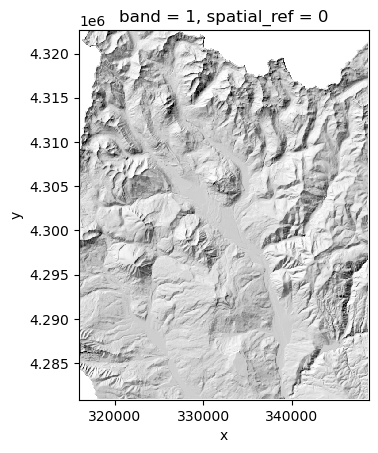

In [4]:
hillshade.plot(cmap='Greys_r', add_colorbar=False)
plt.gca().set_aspect('equal') # so that the axes are sized correctly

We can plot them together. We will plot the hillshade on the bottom, and make the elevation colors see through

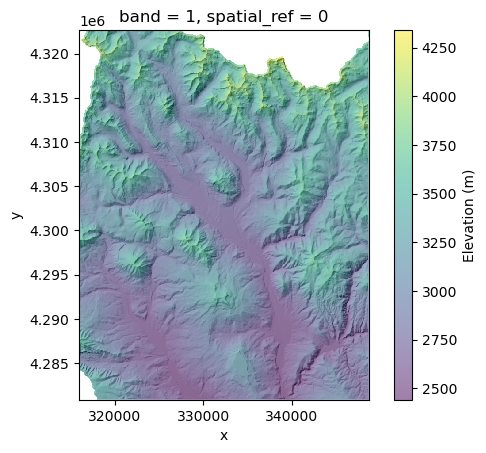

In [5]:
hillshade.plot(cmap='Greys_r', add_colorbar=False)
ax = elevation.plot(alpha=0.5, cbar_kwargs={'label': "Elevation (m)"})
plt.gca().set_aspect('equal') # so that the axes are sized correctly

## Snow DSM

A "DSM" is a digital surface model. The idea is the same as the DEM, except now the pixel values will represent some surface instead of the terrain. For example, a snow dsm has a snow depth value for each pixel. 

Let's plot the snow DSM over the hillshade.

Note that this snow DSM was created from data collected on 1 April 2023, so near the date of maximum snow depth during the winter of the SOS campaign.

In [6]:
snowdepth = rix.open_rasterio("../data/eastriver_snowdepth_2023april01.tif")

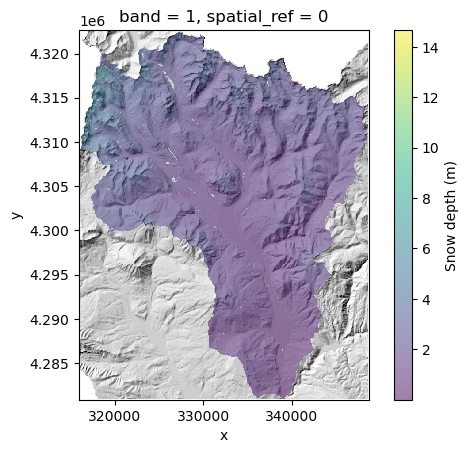

In [7]:
hillshade.plot(cmap='Greys_r', add_colorbar=False)
ax = snowdepth.plot(alpha=0.5, cbar_kwargs={'label': "Snow depth (m)"})
plt.gca().set_aspect('equal') # so that the axes are sized correctly

This doesn't look that great... it looks like all the snowdepth values are below 4 meters. Let's look at the distribution of snow depth values

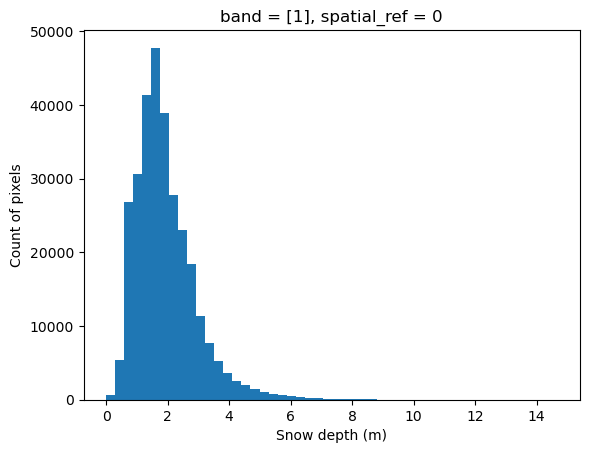

In [9]:
snowdepth.plot.hist(bins=50)
plt.xlabel('Snow depth (m)')
plt.ylabel('Count of pixels')
plt.show()

OK so if we shrink the colorbar, we should see more detail. Let's make our maximum plotted snow depth value 4m. Let's also change the color bar to blues so that shallow snow is white-ish, deep snow is deep blue.

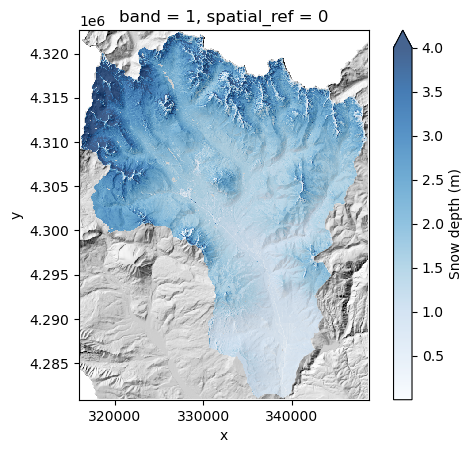

In [10]:
hillshade.squeeze().plot(cmap='Greys_r', add_colorbar=False)
ax = snowdepth.squeeze().plot(cmap='Blues', alpha=0.75, vmax=4, cbar_kwargs={'label': "Snow depth (m)"})
plt.gca().set_aspect('equal') # so that the axes are sized correctly

OK so what we see makes sense - higher elevation areas have more snow. Also, it appears that more snow fall in the northern portion of our domain, particularly in the NE corner.

Where is Kettle Ponds (our measurement site) on this map? And if this snowdepth map is for the whole East River Valley, what comprises the Upper East River Valley?

Let's open up a boundary for the Upper East River Valley and create a "GeoSeries" with the lat/long of the Kettle Ponds site, and plot both on top of the map above. We used these mapping features in Lab2-1.

In [14]:
upper_east_river_polygon = gpd.read_file('../data/east_polygon.json').to_crs(
    snowdepth.rio.crs
)

In [17]:
# Create a dataseries for the two locations of the snotels.
# We also add in the location of Kettle Ponds manually
# Note we give it a "CRS" coordinate reference system which corresponds to the Latitude Longitude points provided in the dataframe above
                            # This is the location of Kettle Ponds
kps_loc = gpd.GeoSeries([Point(-106.972983, 38.941817, 0)],
    index = ['Kettle Ponds'],
    crs = 'epsg:4326'
).to_crs(snowdepth.rio.crs)
kps_loc

Kettle Ponds    POINT Z (329008.940 4312170.815 0.000)
dtype: geometry

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

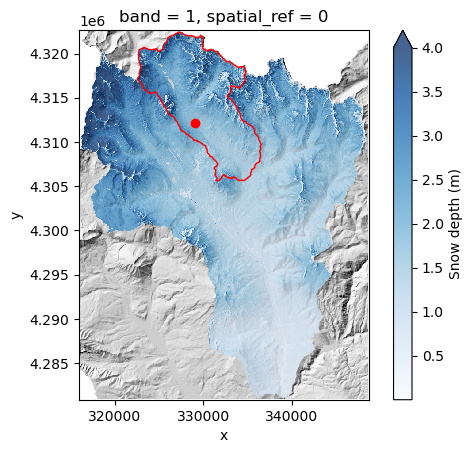

In [18]:
fig, ax = plt.subplots()
hillshade.squeeze().plot(cmap='Greys_r', add_colorbar=False, ax=ax)
snowdepth.squeeze().plot(cmap='Blues', alpha=0.75, vmax=4, cbar_kwargs={'label': "Snow depth (m)"}, ax=ax)
plt.gca().set_aspect('equal') # so that the axes are sized correctly
kps_loc.plot(color='red', ax=ax)
upper_east_river_polygon.plot(edgecolor='red', facecolor='None', ax=ax)

The red dot above shows Kettle Ponds. The red outline shows the "Upper" East River watershed. The snow depth map is for the *whole* East River watershed.

OK so we've been looking at a much larger area than we are used to. Let's clip the DEMs/DSMs and zoom in on the Upper East River Valley and look again.

In [22]:
hillshade_clipped = hillshade.rio.clip_box(
    *upper_east_river_polygon.geometry.iloc[0].bounds
)
snowdepth_clipped = snowdepth.rio.clip_box(
    *upper_east_river_polygon.geometry.iloc[0].bounds
)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

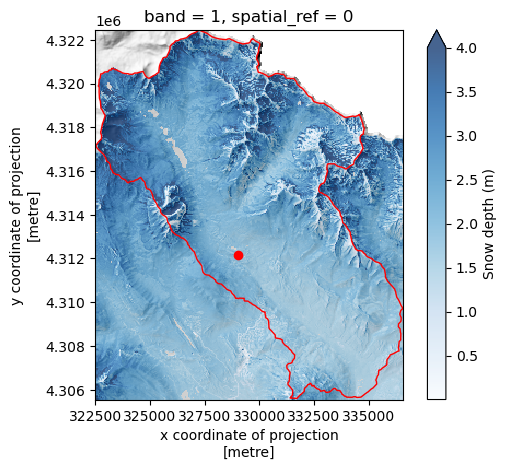

In [23]:
fig, ax = plt.subplots()
hillshade_clipped.squeeze().plot(cmap='Greys_r', add_colorbar=False, ax=ax)
snowdepth_clipped.squeeze().plot(cmap='Blues', alpha=0.75, vmax=4, cbar_kwargs={'label': "Snow depth (m)"}, ax=ax)
plt.gca().set_aspect('equal') # so that the axes are sized correctly
kps_loc.plot(color='red', ax=ax)
upper_east_river_polygon.plot(edgecolor='red', facecolor='None', ax=ax)

Let's zoom in even further...

First we will zoom in to Gothic Mountain

(324000.0, 328000.0)

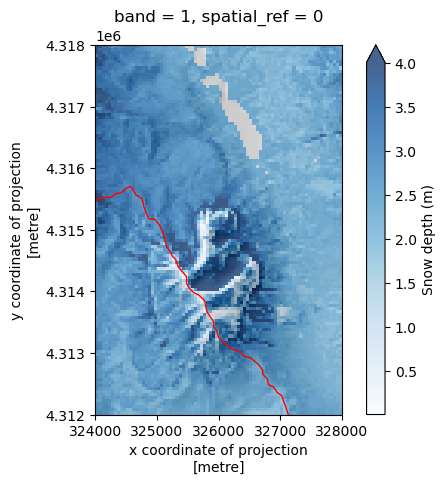

In [24]:
fig, ax = plt.subplots()
hillshade_clipped.squeeze().plot(cmap='Greys_r', add_colorbar=False, ax=ax)
snowdepth_clipped.squeeze().plot(cmap='Blues', alpha=0.75, vmax=4, cbar_kwargs={'label': "Snow depth (m)"}, ax=ax)
plt.gca().set_aspect('equal') # so that the axes are sized correctly
kps_loc.plot(color='red', ax=ax)
upper_east_river_polygon.plot(edgecolor='red', facecolor='None', ax=ax)
plt.ylim(4.312e6, 4.318e6)
plt.xlim(324000, 328000)

We can see that a large amount of snow has settled on the east side of Gothic mountain, particularly in a rounded couloir

Let's zoom into a different area

(327500.0, 331500.0)

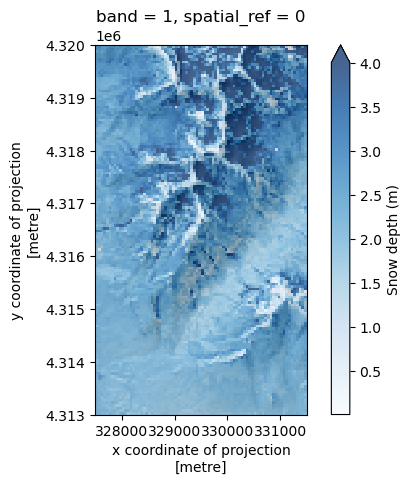

In [25]:
fig, ax = plt.subplots()
hillshade_clipped.squeeze().plot(cmap='Greys_r', add_colorbar=False, ax=ax)
snowdepth_clipped.squeeze().plot(cmap='Blues', alpha=0.75, vmax=4, cbar_kwargs={'label': "Snow depth (m)"}, ax=ax)
plt.gca().set_aspect('equal') # so that the axes are sized correctly
kps_loc.plot(color='red', ax=ax)
upper_east_river_polygon.plot(edgecolor='red', facecolor='None', ax=ax)
plt.ylim(4.313e6, 4.320e6)
plt.xlim(327500, 331500)

From this north-south aligned ridge, it appears that more snow is settling on the east side of the ridge than on the left!

Can we quantify this?  

Let's open up some "transect" lines that we will use to extract data from the rasters.

In [26]:
transects = gpd.read_file("../data/transects.shp")

Let's look at where the transects are on our map

(4312000.0, 4320000.0)

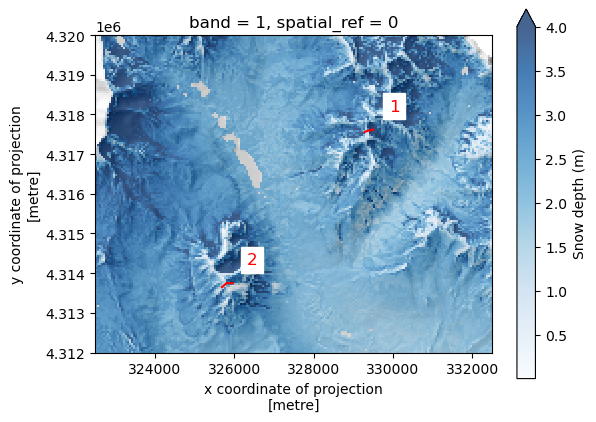

In [27]:
fig, ax = plt.subplots()
hillshade_clipped.squeeze().plot(cmap='Greys_r', add_colorbar=False, ax=ax)
snowdepth_clipped.squeeze().plot(cmap='Blues', alpha=0.75, vmax=4, cbar_kwargs={'label': "Snow depth (m)"}, ax=ax)

transects.plot(ax=ax, color='red')

# This adds annotations to label the transects by number
transects.apply(lambda x: ax.annotate(
    text=x['id'], 
    xy=np.array(x.geometry.centroid.coords[0])+500, 
    ha='left', 
    size=12, 
    backgroundcolor='white', 
    color='red'), axis=1
)


plt.gca().set_aspect('equal') # so that the axes are sized correctly
plt.xlim(322500, 332500)
plt.ylim(4.312e6, 4.320e6)

OK so we now have transect lines that cross ridges, from west to east.

Using the points within these transects, we will extract elevation and snow depth values, and plots profiles of the elevation and the snow depth on top of that elevation, to see how snowdepth varies across two ridges.

Let's now extract elevation and elevation plus snow depth values along each point in that transect.

First, let's create a raster/dataset that is elevation + snow depth! 

In [29]:
elev_plus_snowdepth = elevation + snowdepth

Now, let's extract elevation and elevation+snowdepth values from the datasets. First, let's get a closer look at the transect and the snowdepth/elevation below.

#### Transect 1

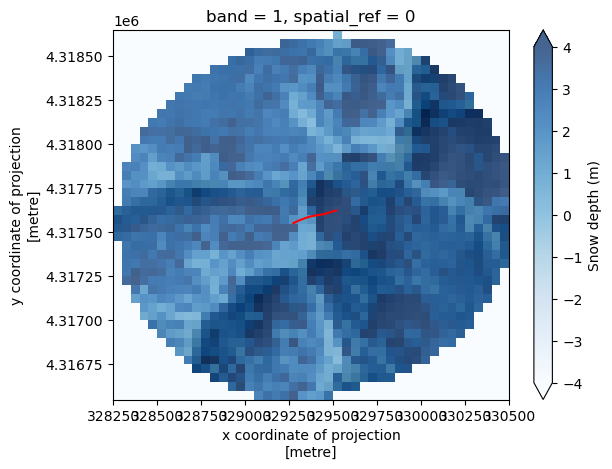

In [55]:
transect_1_dataset = transects.iloc[:1]
fig, ax = plt.subplots()
hillshade_clipped.rio.clip( # this call to `clip` is create a 1km buffer around the transect line so we can zoom in on the dataset
    transect_1_dataset.buffer(1000)
).squeeze().plot(cmap='Greys_r', add_colorbar=False, ax=ax)
snowdepth_clipped.rio.clip( # this call to `clip` is create a 1km buffer around the transect line so we can zoom in on the dataset
    transect_1_dataset.buffer(1000)
).squeeze().plot(cmap='Blues', alpha=0.75, vmax=4, cbar_kwargs={'label': "Snow depth (m)"}, ax=ax)

transect_1_dataset.plot(ax=ax, color='red')
plt.gca().set_aspect('equal') # so that the axes are sized correctly

In [56]:
# extract elevation values
transect1_elevation_values = np.array([
    elevation.sel(
        x=coord[0],
        y=coord[1],
        method='nearest'
    ).values.item() for coord in transects.geometry[0].coords
])

# extract snowdepth+elevation values
transect1_snowdepth_values = np.array([
    elev_plus_snowdepth.sel(
        x=coord[0],
        y=coord[1],
        method='nearest'
    ).values.item() for coord in transects.geometry[0].coords
])
resolution = transects.geometry[0].length / 50
transect1_xdistance_values = np.arange(0, len(transects.geometry[0].coords)) * resolution

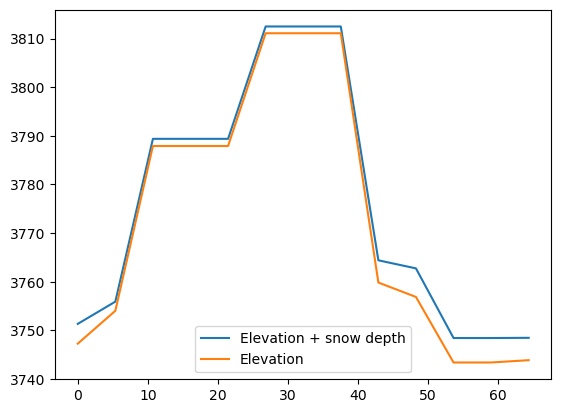

In [57]:
plt.plot(
    transect1_xdistance_values,
    transect1_snowdepth_values,
    label='Elevation + snow depth'
)
plt.plot(
    transect1_xdistance_values,
    transect1_elevation_values,
    label='Elevation'
)
plt.legend()

For the second transect (this is the transect in the lower left of the map above)

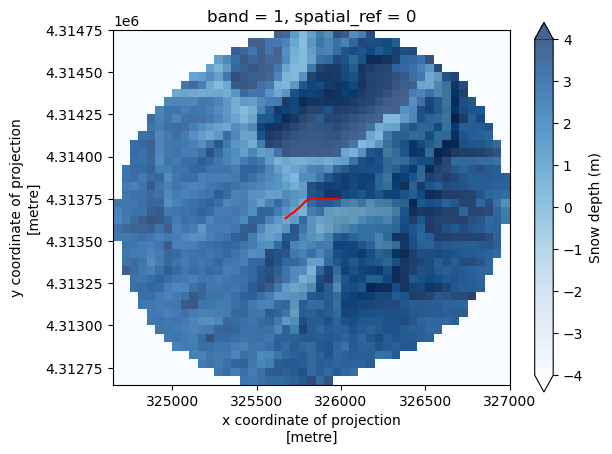

In [58]:
transect_2_dataset = transects.iloc[1:]
fig, ax = plt.subplots()
hillshade_clipped.rio.clip( # this call to `clip` is create a 1km buffer around the transect line so we can zoom in on the dataset
    transect_2_dataset.buffer(1000)
).squeeze().plot(cmap='Greys_r', add_colorbar=False, ax=ax)
snowdepth_clipped.rio.clip( # this call to `clip` is create a 1km buffer around the transect line so we can zoom in on the dataset
    transect_2_dataset.buffer(1000)
).squeeze().plot(cmap='Blues', alpha=0.75, vmax=4, cbar_kwargs={'label': "Snow depth (m)"}, ax=ax)

transect_2_dataset.plot(ax=ax, color='red')
plt.gca().set_aspect('equal') # so that the axes are sized correctly

In [59]:
# extract elevation values
transect2_elevation_values = np.array([
    elevation.sel(
        x=coord[0],
        y=coord[1],
        method='nearest'
    ).values.item() for coord in transects.geometry[1].coords
])

# extract snowdepth+elevation values
transect2_snowdepth_values = np.array([
    elev_plus_snowdepth.sel(
        x=coord[0],
        y=coord[1],
        method='nearest'
    ).values.item() for coord in transects.geometry[1].coords
])
resolution = transects.geometry[1].length / 50
transect2_xdistance_values = np.arange(0, len(transects.geometry[1].coords)) * resolution

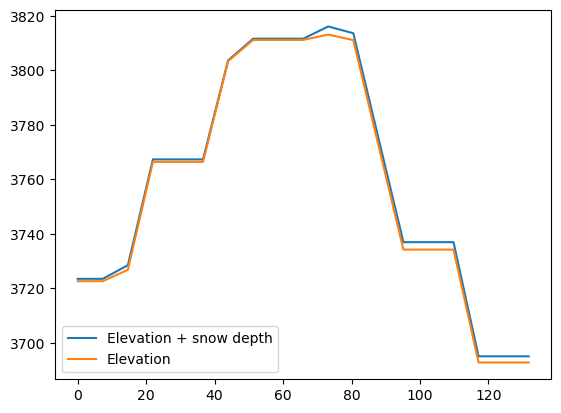

In [60]:
plt.plot(
    transect2_xdistance_values,
    transect2_snowdepth_values,
    label='Elevation + snow depth'
)
plt.plot(
    transect2_xdistance_values,
    transect2_elevation_values,
    label='Elevation'
)
plt.legend()

So, we can see that, even though the elevation and snowdepth datasets are quite coarse, there is more snow on the westerly side of the ridges than on the easterly sides.

Can we estimate the difference in snowdepth across the ridge?

For transect 2 (plot immediately above), let's say the ridge crest is at x=60 meters. Split the data at that value and calculate the mean snowdepth value on either side of the ridge.

In [64]:
west_side_xdistance = transect2_xdistance_values[:9] # the 9 here is just the position in the list of where we want to split the transect profile values
east_side_xdistance = transect2_xdistance_values[9:]
east_side_mean_snowdepth = (transect2_snowdepth_values[:9] - transect2_elevation_values[:9]).mean()
west_side_mean_snowdepth = (transect2_snowdepth_values[9:] - transect2_elevation_values[9:]).mean()
east_side_mean_snowdepth, west_side_mean_snowdepth

(0.8138020833333334, 2.3519775390625)

So the snowdepth was, on average, 81cm cm on the east side of the ridge and 235cm on the west side of the ridge!

What about for transect1?

In [65]:
west_side_xdistance = transect1_xdistance_values[:7] # the 7 here is just the position in the list of where we want to split the transect profile values
east_side_xdistance = transect1_xdistance_values[7:]

west_side_xdistance, east_side_xdistance

east_side_mean_snowdepth = (transect1_snowdepth_values[:7] - transect1_elevation_values[:7]).mean()
west_side_mean_snowdepth = (transect1_snowdepth_values[7:] - transect1_elevation_values[7:]).mean()
east_side_mean_snowdepth, west_side_mean_snowdepth

(1.8778948102678572, 4.412760416666667)

So the snowdepth was, on average, 188 cm on the east side of the ridge and 4.41cm on the west side of the ridge!